# GGM exporteren tbv GEMMA

Dit notebook wordt gebruikt om vanuit de beschikbare versie van het [Gemeentelijk Gegevensmodel](https://github.com/Gemeente-Delft/Gemeentelijk-Gegevensmodel) een export te maken van van het GGM zodat deze in de GEMMA ingelezen kan worden. Dit in het kader van de uitwisseling met de GEMMA. Alle beoogde uitwisselingen in het kader van de uitwisseling van het GGM met de GEMMA zijn in onderstaande afbeelding weergegeven.

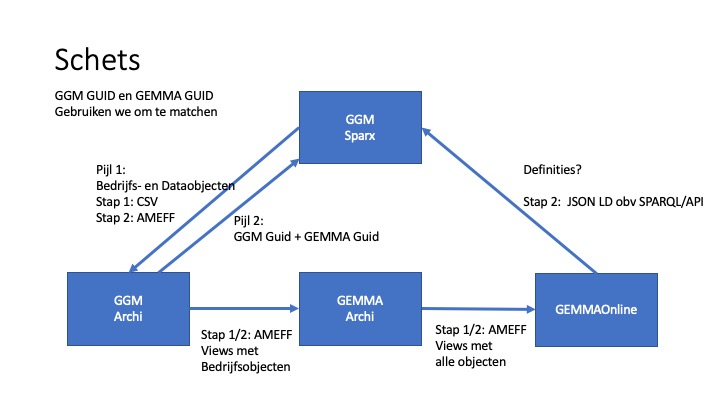

Dit notebook verzorgt de export vanuit het GGM naar de GEMMA conform Pijl 1, Stap 1 in de afbeelding. De gegevens worden geëxporteerd conform de afspraken vastgelegd in [Uitwisseling GGM en GEMMA](https://github.com/Gemeente-Delft/Gemeentelijk-Gegevensmodel/tools/docs/Uitwisseling_GGM_en_GEMMA.pptx) De volgende definities worden geëxporteerd: 

1. objecttypes
2. relaties

## Werking Export

De exportmodule maakt gebruik van het feit dat het GGM is vastgelegd in Enterprise Architect van Sparx en dat deze de repository van het GGM in [Sqllite](https://www.sqlite.org/index.html) wordt bijgehouden. Deze exportmodule leest de benodigde tabellen uit de repository, voegt ze samen en maakt een exportbestand dat naar GEMMA verstuurd kan worden.


In [1]:
### Importeer bibliotheken en utils

import os
import pandas as pd
import json
from IPython.display import JSON as JSONDisplay
import requests
import database
import util
from re import sub
import ast
import re
from treelib import Node, Tree
from datetime import datetime, timezone
import pytz

import sqlalchemy as sa
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, inspect
from sqlalchemy.engine import reflection

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, Sequence
from sqlalchemy.dialects.postgresql import insert
import uuid

def generateEAUUID():
    return '{' +  str(uuid.uuid4()).upper() + '}'

## Configuratie

Met de waarden hieronder configureer je de export. Met root_guid geef je de root in de repository weer vanwaar (en alles eronder) geexporteerd moet worden. Op deze manier kun je ook deelmodellen exporteren. Als voorbeeld zijn naast de root van het hele GGM ook Onderwijs en monumenten getoond.  

In [2]:
### Configuratie
db_uri = "sqlite:////home/jovyan/root/gemeentelijk gegevensmodel EA16.qea"

now = datetime.now()
dt_string = now.strftime("%d%m%Y-%H:%M:%S")
output_objects = f"/home/jovyan/output/ggm_export_objects_{dt_string}.csv"
output_relations = f"/home/jovyan/output/ggm_export_relations_{dt_string}.csv"
#output_attributes = f"./output/ggm_export_attributes_{dt_string}.csv"

root_guid = '{604AC59D-D038-4e78-A5FA-80E4748DED5B}' #Om te experimenteren: Onderwijs in package ontwikkeling
root_guid = '{45B88627-6F44-4b6d-BE77-3EC51BBE679E}' #Om te experimenteren: Monumenten
root_guid = '{58A5214F-E56C-4707-BE2D-AB36DD6976A3}' #Om te experimenteren: RSGB
root_guid = '{D7FD597E-1F40-48df-AFFC-EA3B5B5D3FBF}' # Root GGM

obj_columns = ['GGM-naam', 'GGM-definitie', 'GGM-uml-type', 'GGM-toelichting', 'GGM-synoniemen', 'GGM-guid', 'GGM-bron', 'domein-iv3', 'domein-dcat', 'domein-gemma', 'GEMMA-naam', 'GEMMA-definitie', 'GEMMA-toelichting', 'GEMMA-synoniemen', 'GEMMA-bron', 'GEMMA-URL', 'GEMMA-alternate-name', 'GEMMA-guid', 'GEMMA-type', 'datum-tijd-export'] 
obj_column_mapping = {'name': 'GGM-naam', 'object_type': 'GGM-uml-type', 'ea_guid': 'GGM-guid', 'herkomst': 'GGM-bron', 'note': 'GGM-definitie', 'toelichting': 'GGM-toelichting', 'synoniemen': 'GGM-synoniemen', 'archimate-type': 'GEMMA-type', 'gemma-guid': 'GEMMA-guid'}

#obj_columns = ['GGM-naam', 'GEMMA-naam', 'GGM-guid', 'GEMMA-guid', 'GEMMA-type', 'GGM-uml-type', 'GGM-definitie', 'GEMMA-definitie', 'GGM-toelichting', 'GEMMA-toelichting', 'GGM-synoniemen', 'GEMMA-synoniemen', 'GGM-bron', 'GEMMA-bron', 'GEMMA-URL', 'GEMMA-alternate-name', 'domein-dcat', 'domein-iv3', 'Datum-tijd-export'] 
#obj_column_mapping = {'ea_guid': 'GGM-guid', 'name': 'GGM-naam', 'herkomst': 'GGM-bron', 'objectnote': 'GGM-definitie', 'synoniemen': 'GGM-synoniemen', 'toelichting': 'GGM-toelichting'}

#attr_columns = ['naam', 'definitie', 'archimate-datatype', 'uml-datatype', 'gemma-guid', 'ggm-guid', 'gemma-object-guid', 'ggm-object-guid', 'bron', 'toelichting', 'synoniemen', 'datum-tijd-export'] 
#attr_column_mapping = {'name': 'naam', 'type': 'uml-datatype', 'ea_guid': 'ggm-guid', 'ea_guid_object': 'ggm-object-guid', 'herkomst': 'bron', 'notes': 'definitie'}

con_columns = ['naam', 'definitie', 'archimate-type', 'uml-type', 'gemma-guid', 'ggm-guid', 'gemma-source-guid', 'gemma-target-guid', 'ggm-source-guid', 'ggm-target-guid', 'toelichting', 'datum-tijd-export'] #, 'domein-iv3', 'domein-dcat', 'domein-gemma'] 
con_columns = ['GGM-naam', 'GGM-definitie', 'GGM-uml-type', 'GGM-toelichting', 'GGM-guid', 'GGM-source-guid', 'GGM-target-guid', 'GEMMA-naam', 'GEMMA-definitie', 'GEMMA-toelichting', 'GEMMA-type', 'GEMMA-guid', 'GEMMA-source-guid', 'GEMMA-target-guid', 'datum-tijd-export'] 
con_column_mapping = {'connector_name': 'GGM-naam', 'connector_type': 'GGM-uml-type', 'ea_guid': 'GGM-guid', 'note': 'GGM-definitie', 'toelichting': 'GGM-toelichting', 'ea_guid_source': 'GGM-source-guid', 'ea_guid_target': 'GGM-target-guid'}

## Inlezen Objecttypes

Hieronder wordt het model (vanaf 'root_guid' en alles daaronder) ingelezen in het dataframe df voor verdere verwerking. Achtereenvolgens worden de volgende stappen genomen:

1. alle packages (in een tree)
2. alle objecten (classes, enumeraties en waardelijsten) met alle waarden.
3. filteren van objecten op de te exporteren waardes

In [3]:
# Alle packages inlezen en omzetten in tree structure
df_package = database.get_df(db_uri, "select * from t_package")
df_package['Name'] = df_package['Name'].apply(lambda x: util.verwijder_getallen_en_blanks_vooraan(x))

# Zoek de ID van de root value and get Package tree
root_id = df_package[df_package.ea_guid == root_guid]['Package_ID'].values[0]
package_tree = util.DataframeToTree(df_package, 'Package_ID', 'Parent_ID', 4)
#package_tree.show()

df_package

,Package_ID,Name,Parent_ID,CreatedDate,ModifiedDate,Notes,ea_guid,XMLPath,IsControlled,LastLoadDate,...,PkgOwner,UMLVersion,UseDTD,LogXML,CodePath,Namespace,TPos,PackageFlags,BatchSave,BatchLoad
0,2,Delfts Gemeentelijk Gegevensmodel,0,2012-04-17 00:00:00,2018-03-27 18:23:07,None,{073A3334-C42A-41a6-A0C6-38DFF8C70236},Delfts Gemeentelijk Gegevensmodel.xml,0,2019-08-15 17:26:27,...,Arjen Brienen,Enterprise Architect XMI 2.1/UML 2.1,0,0,None,None,0,isModel=1;Recurse=1;CRC=14b684c6;,0,0
1,4,Gemeentelijk Gegevensmodel,2,2018-04-04 15:03:05,2024-04-17 13:35:04,None,{D7FD597E-1F40-48df-AFFC-EA3B5B5D3FBF},C:\Users\aashkpour\OneDrive - Gemeente Delft\D...,1,2018-05-09 13:45:08,...,None,Enterprise Architect XMI 2.1/UML 2.1,0,1,None,None,1,Recurse=1;VPK=7;VPKG=7;,1,1
2,5,"Bestuur, Politiek en Ondersteuning",4,2023-10-12 14:31:31,2024-04-17 13:34:24,None,{47DC5ADA-17D7-49e1-8BC6-F798EE72B111},None,0,2023-10-12 16:27:45,...,None,None,0,0,None,None,1,None,0,0
3,6,Burgerzaken,5,2018-04-04 15:05:22,2024-04-17 13:34:23,None,{C84D590F-615F-4671-B4C2-7610C80F33F4},None,0,2018-11-07 17:34:38,...,None,None,0,0,None,None,0,None,0,0
4,7,Diagram,6,2018-07-12 16:10:28,2024-04-17 13:34:23,None,{3F06C9A2-5353-4e00-A10F-F0F73382C8B0},None,0,2018-11-07 17:34:38,...,None,None,0,0,None,None,0,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
280,367,Tables,366,2019-12-11 11:48:06,2024-04-17 13:41:51,None,{565E4A65-9197-453c-9B37-02FEFE52C41E},None,0,2019-12-16 13:52:23,...,None,None,0,0,None,1,0,None,0,0
281,368,Tabellen Voorbeeld C,363,2019-12-10 11:53:17,2024-04-17 13:41:51,None,{63EE50AA-4F12-4724-9766-A452C1AACD70},None,0,2019-12-16 13:52:23,...,None,None,0,0,None,None,0,None,0,0
282,369,Tables,368,2019-12-11 12:45:58,2024-04-17 13:41:51,None,{11B8A7FC-8469-453c-9282-3F5BD673B36F},None,0,2019-12-16 13:52:23,...,None,None,0,0,None,1,0,None,0,0
283,370,Tabellen Voorbeeld D,363,2020-05-08 10:47:58,2024-04-17 13:41:51,None,{A4D96EA9-EE8E-4cad-8409-540E4C728E58},None,0,2020-12-10 13:17:22,...,None,None,0,0,None,None,0,None,0,0


In [4]:
#Allereerst alle objectgegevens verzamelen en combineren

# alle objecten (packages, classes, enumeraties en waardelijsten)
df_obj = database.get_df_objectsHierar(db_uri, root_guid=root_guid)
df_obj.dropna(subset='name', inplace=True)

#Packages hebben we niet bodig voor export
df_obj = df_obj[df_obj.object_type != 'Package']

# lees alle object properties. Pivot de verschillede rijen met properties naar een tabel met index Object_ID.
df_objprop = database.get_df(db_uri, 'select * from t_objectproperties')
df_objprop = df_objprop.pivot(index="Object_ID", columns="Property", values="Value")
df_objprop.reset_index(inplace=True)
df_objprop.drop(columns=['Toelichting'], inplace=True)
#df_objprop.columns = df_objprop.columns.str.lower()

# Join per object de gevonden property rij
df_obj = df_obj.merge(df_objprop, how='left', left_on='object_id', right_on='Object_ID', suffixes=('','_y'))



# IV3-model moet worden afgeleid uit de tree structuur van package
def getIV3Domein(packageID):
    node = package_tree.get_node(packageID)
    if not node:
        return None
    tag = node.tag
    tag = util.verwijder_getallen_en_blanks_vooraan(tag)
    if not tag.startswith('Model') and not tag.startswith('Diagram'):
        return tag
    else:
        return getIV3Domein(package_tree.parent(packageID).identifier) 

df_obj['domein-iv3'] = df_obj.apply(lambda x: getIV3Domein(x['package_id']), axis=1)
df_obj

,object_id,object_type,stereotype,name,alias,author,version,objectnote,ea_guid,modifieddate,...,Unieke aanduiding objecttype,Unieke aanduiding referentielijst,datum-tijd-export,domein-dcat,domein-gemma,domein-iv3,herkomst,name_y,synoniemen,toelichting
0,12,Class,proxy,AanwezigeDeelnemer,None,Arjen Brienen,1.0,iemand die meedoet aan eencollege- of raadsver...,{F1E55DC7-0F33-40ea-8713-2E1AC3D7EE8D},2024-04-17 13:34:23,...,NaN,NaN,10-04-2024 17:26:26,,,Griffie,,Aanwezige Deelnemer,,
1,13,Class,None,Agendapunt,None,Arjen Brienen,1.0,Een onderwerp dat in de vergadering wordt beha...,{73FB5212-40ED-40dc-B837-36588840445A},2024-04-17 13:34:24,...,NaN,NaN,10-04-2024 17:26:26,,,Griffie,,Agendapunt,,
2,14,Class,None,Categorie,None,Arjen Brienen,1.0,Categorie waarop leveranciers zich voor de lev...,{B9B82B25-5D7F-4d2b-84F9-4DF74525EEAD},2024-04-17 13:34:24,...,NaN,NaN,28062023-11:06:06,,,Griffie,NaN,NaN,,
3,15,Class,None,Collegelid,None,Arjen Brienen,1.0,Iemand die behoort het college van burgemeeste...,{7B9EDDFD-57F7-4ff2-938F-FDFA3B503DA8},2024-04-17 13:34:24,...,NaN,NaN,10-04-2024 17:26:26,,,Griffie,,Collegelid,,
4,16,Class,None,Raadscommissie,None,Arjen Brienen,1.0,Een raadscommissie binnen de Nederlandse gemee...,{CB27D699-F82B-45ad-823A-B2B51BCAECBA},2024-04-17 13:43:38,...,NaN,NaN,10-04-2024 17:26:26,,,Griffie,,Raadscommissie,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,1302,Enumeration,None,typeringScheiding,None,debat_e,1.0,De verschillende waarden die de typering van e...,{46243659-A179-4d8d-9356-21680DA327E5},2024-04-17 13:35:03,...,NaN,NaN,28062023-11:06:06,,,Enumeratiesoort,NaN,NaN,,
1025,1303,Enumeration,None,typeringVegetatieobject,None,debat_e,1.0,De verschillende waarden die de typeringen van...,{B92F9DEF-A728-4425-BF33-2CCA3090CE70},2024-04-17 13:35:03,...,NaN,NaN,28062023-11:06:06,,,Enumeratiesoort,NaN,NaN,,
1026,1304,Enumeration,None,typeringWater,None,debat_e,1.0,De verschillende waarden die de typering van h...,{61B9BC8D-DC58-4f6c-9EA7-11AD6101176B},2024-04-17 13:35:03,...,NaN,NaN,28062023-11:06:06,,,Enumeratiesoort,NaN,NaN,,
1027,1305,Enumeration,None,typeringWaterPlus,None,debat_e,1.0,De verschillende waarden die een nadere catego...,{207728DF-D25F-4166-93DD-12EA3736161E},2024-04-17 13:35:03,...,NaN,NaN,28062023-11:06:06,,,Enumeratiesoort,NaN,NaN,,


In [5]:
'''
Check exportvelden zoals afgesproken in Powerpoint
'''

## Set the right columns
df_obj_export = util.exportColumns(df_obj, obj_columns, obj_column_mapping)   
df_obj_export['datum-tijd-export'] = dt_string
df_obj_export

#Foutje met dubbele kolom toelichting
df_obj_export['toelichting_save'] = df_obj_export.apply(lambda row: ' '.join([str(x) for x in row[['GGM-toelichting']] if pd.notna(x)]), axis=1)
df_obj_export.drop(columns='GGM-toelichting', inplace=True)
df_obj_export.rename(columns={'toelichting_save': 'GGM-toelichting'}, inplace=True)

df_obj_export

,GGM-naam,GGM-definitie,GGM-uml-type,GGM-synoniemen,GGM-guid,GGM-bron,domein-iv3,domein-dcat,domein-gemma,GEMMA-naam,GEMMA-definitie,GEMMA-toelichting,GEMMA-synoniemen,GEMMA-bron,GEMMA-URL,GEMMA-alternate-name,GEMMA-guid,GEMMA-type,datum-tijd-export,GGM-toelichting
0,AanwezigeDeelnemer,iemand die meedoet aan eencollege- of raadsver...,Class,,{F1E55DC7-0F33-40ea-8713-2E1AC3D7EE8D},,Griffie,,,Aanwezige Deelnemer,iemand die meedoet aan eencollege- of raadsver...,,,,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,,ccf78bc5-8d4a-440f-a642-abcf60149628,business-object,14082024-08:34:36,
1,Agendapunt,Een onderwerp dat in de vergadering wordt beha...,Class,,{73FB5212-40ED-40dc-B837-36588840445A},,Griffie,,,Agendapunt,Een onderwerp dat in de vergadering wordt beha...,,,,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,,34b2e5f9-63ab-42e8-bfa9-85e12ff6e417,business-object,14082024-08:34:36,
2,Categorie,Categorie waarop leveranciers zich voor de lev...,Class,,{B9B82B25-5D7F-4d2b-84F9-4DF74525EEAD},NaN,Griffie,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36,
3,Collegelid,Iemand die behoort het college van burgemeeste...,Class,,{7B9EDDFD-57F7-4ff2-938F-FDFA3B503DA8},,Griffie,,,Collegelid,Iemand die behoort het college van burgemeeste...,,,,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,,d0eb8d8b-25c9-4eef-9dc6-4a773d8899a7,business-object,14082024-08:34:36,
4,Raadscommissie,Een raadscommissie binnen de Nederlandse gemee...,Class,,{CB27D699-F82B-45ad-823A-B2B51BCAECBA},,Griffie,,,Commissie,Een groep mensen die is samengesteld om een sp...,,,,https://gemmaonline.nl/index.php/GEMMA2/0.9/id...,,62126697-6498-4c0a-a84e-2275138c2eaa,business-object,14082024-08:34:36,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1024,typeringScheiding,De verschillende waarden die de typering van e...,Enumeration,,{46243659-A179-4d8d-9356-21680DA327E5},NaN,Enumeratiesoort,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36,
1025,typeringVegetatieobject,De verschillende waarden die de typeringen van...,Enumeration,,{B92F9DEF-A728-4425-BF33-2CCA3090CE70},NaN,Enumeratiesoort,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36,
1026,typeringWater,De verschillende waarden die de typering van h...,Enumeration,,{61B9BC8D-DC58-4f6c-9EA7-11AD6101176B},NaN,Enumeratiesoort,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36,
1027,typeringWaterPlus,De verschillende waarden die een nadere catego...,Enumeration,,{207728DF-D25F-4166-93DD-12EA3736161E},NaN,Enumeratiesoort,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36,


## Inlezen Relatiesoorten

Hieronder wordt het model (vanaf 'root_guid' en alles daaronder) ingelezen in het dataframe df voor verdere verwerking. Achtereenvolgens worden de volgende stappen genomen:

1. alle connecties inlezen
2. koppelen source en dest objecten
3. alle properties inlezen en koppelen
4. filteren op te exporteren waardes

In [6]:
# inlezen alle relaties bij deze objecten
# alle relaties (associaties en generatiesaties) die bij start of einde een object uit de subset hebben worden meegenomen

df_con = database.get_df(db_uri, database.sql_connectors).rename(columns={'connector_ea_guid':'ea_guid'})
df_con = df_con.merge(df_obj[['object_id', 'ea_guid', 'domein-iv3']], right_on='object_id', left_on='start_object_id', how='inner', suffixes=['', '_source'])
df_con = df_con.merge(df_obj[['object_id', 'ea_guid']], right_on='object_id', left_on='end_object_id', how='inner', suffixes=['', '_target'])
df_con.drop_duplicates('connector_id', inplace=True)


# lees alle relatie properties. Pivot de verschillede rijen met properties naar een tabel met index Element_ID.
df_conprop = database.get_df(db_uri, 'select * from t_connectortag')
df_conprop = df_conprop.pivot(index="ElementID", columns="Property", values="VALUE")
df_conprop.reset_index(inplace=True)
#df_conprop.columns = df_conprop.columns.str.lower()

# Join per object de gevonden property rij
df_con = df_con.merge(df_conprop, how='left', left_on='connector_id', right_on='ElementID')
df_con.head(5)

,connector_name,connector_type,start_object_id,end_object_id,connector_sourcecard,connector_destcard,connector_sourcerole,connector_destrole,top_start_label,top_mid_label,...,Indicatie in onderzoek,Indicatie materiële historie,Mogelijk geen waarde,Naam terugrelatie,Regels,Regels relatiesoort,Toelichting,Toelichting relatiesoort,datum-tijd-export,toelichting
0,naam4,Association,1322,1324,0..*,1,None,None,None,naam4,...,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN,NaN,NaN
1,naam3,Association,1322,1323,0..*,1,None,None,None,naam3,...,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN,NaN,NaN
2,naam2 (werkwoord),Association,1321,1319,0..*,1..*,None,None,None,naam2 (werkwoord),...,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN,NaN,NaN
3,naam1 (werkwoord),Association,1318,1319,1,0..*,None,None,None,naam1 (werkwoord),...,None,None,Nee,NaN,<memo>,NaN,<memo>,NaN,NaN,NaN
4,is specialisatie van,Generalization,1318,1320,None,None,None,None,None,is specialisatie van,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
'''
Check columns zoals afgesproken in Powerpoint

*naam (label)
*definitie
*toelichting
*ggm-guid
*ggm-source-guid
*ggm-target-guid
*gemma-guid
*gemma-source-guid
*gemma-target-guid
*uml-type ( Associatie, Generalisatie, Aggregatie)
*archimate-type (Association, Generalisatie, Aggregation)
*datum-tijd-export (ddmmyyyy-hh:mm:ss)
'''

df_con_export = util.exportColumns(df_con, con_columns, con_column_mapping)    
df_con_export = df_con_export.loc[:,~df_con_export.columns.duplicated()].copy()
df_con_export['datum-tijd-export'] = dt_string
df_con_export.head(5)

,GGM-naam,GGM-definitie,GGM-uml-type,GGM-toelichting,GGM-guid,GGM-source-guid,GGM-target-guid,GEMMA-naam,GEMMA-definitie,GEMMA-toelichting,GEMMA-type,GEMMA-guid,GEMMA-source-guid,GEMMA-target-guid,datum-tijd-export
0,naam4,None,Association,NaN,{476E7F9D-D7F2-4279-B35B-981DCDA389E0},{EF4E7B58-F178-4a4f-85C5-A5CD93747A36},{97EE5348-F06A-44cb-A792-7371CF5D2E53},NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36
1,naam3,None,Association,NaN,{EB1ECE1C-9867-46d8-B423-50862C0A344A},{EF4E7B58-F178-4a4f-85C5-A5CD93747A36},{23D170D0-917E-4873-A622-43214405AB3D},NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36
2,naam2 (werkwoord),None,Association,NaN,{18883E50-FEE4-4c26-A82E-28BB87F53C62},{DE4D6CAB-7798-46cd-AE1B-328684681323},{0799B0D1-5067-43e2-8A6F-48FB972225E5},NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36
3,naam1 (werkwoord),None,Association,NaN,{3F495D53-B1CF-4dda-A6CA-903B2ECC735F},{AE553F3F-B8B6-4bd2-A6A1-8051145C823B},{0799B0D1-5067-43e2-8A6F-48FB972225E5},NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36
4,is specialisatie van,None,Generalization,NaN,{CA4EDB07-778F-42c4-85ED-A5FE4AF8B21F},{AE553F3F-B8B6-4bd2-A6A1-8051145C823B},{889A7DC6-B389-4e02-BB53-CC0B2B5B0D91},NaN,NaN,NaN,NaN,NaN,NaN,NaN,14082024-08:34:36


## Exporteren CSV's

De CSV's voor de objecten en relaties wegschrijven

In [8]:
print(f"exporting to {output_objects}")
# eerst de index hernoemen zodat deze in de CSV terechtkomt
df_obj_export.drop(columns='nr', inplace=True, errors='ignore')
df_obj_export.index.name = 'nr'
df_obj_export = df_obj_export.reset_index()
#Exporteer CSV
df_obj_export.to_csv(output_objects, index=False)


print(f"exporting to {output_relations}")
# eerst de index hernoemen zodat deze in de CSV terechtkomt
df_con_export.drop(columns=['nr',''], inplace=True, errors='ignore')
df_con_export.index.name = 'nr'
df_con_export = df_con_export.reset_index()
#Exporteer CSV
df_con_export.to_csv(output_relations, index=False)


#print(f"exporting to {output_attributes}")
#df_attr_export.to_csv(output_attributes)


exporting to /home/jovyan/output/ggm_export_objects_14082024-08:34:36.csv
exporting to /home/jovyan/output/ggm_export_relations_14082024-08:34:36.csv
